# Techniques of High Performance Computing - Assignment 2

**Name: John Duffy**

**Student Number: 19154676**

## IMPORTANT NOTE

My development laptop is a 2019 MacBook Pro running macOS 10.14 Mojave. Unfortunately, Mojave introduced some OpenCL development issues. However there are workarounds for these as follows.

1.) Use the following to create a context specific to a CPU or GPU:

    ctx = cl.Context(dev_type = cl.device_type.CPU)  # Tell OpenCL to use the CPU device.

    ctx = cl.Context(dev_type = cl.device_type.GPU)  # Tell OpenCL to use the GPU device.

2.) To work around a build caching problem, issue the following bash command:

    export PYOPENCL_NO_CACHE=1

The above two workarounds worked for me. They should not affect the running of this Jupyter Notebook on a non-macOS system.

**If there are any issues with my notebook running relating to the above, then please contact me to resolve.**

## Import Libraries Common to Question 1 & 2.

In [1]:
# Import libraries common to Questions 1 & 2.

import numpy as np
import pyopencl as cl

import matplotlib.pyplot as plt

from scipy.sparse import dia_matrix, csr_matrix, eye, rand
from scipy.sparse.linalg import LinearOperator, cg

# Question 1

## OpenCL CSR Matrix-Vector Product

### Program Description

This program defines a class *LinearOperatorOpenCLAVX2* which is a subclass of *scipy.sparse.linalg.LinearOperator*. 

The class implements the *init* and *matvec* methods of LinearOperator to provide a matrix-vector product.

Instances of the class are inititialised with sparse matrix data passed as parameters to the *init* method. This ensures matrix data is passed to the OpenCL device once during initialisation and not during each matrix-vector product.

### Program Structure

As previously stated the class LinearOperatorOpenCLAVX2 implements the *init* and *matvec* methods of LinearOperator.

#### The init Method

The majority of the complexity of the class resides in the init method. The *init* method takes the following as paramters:

- **M** The number of rows of the sparse matrix
- **N** The number of columns of the sparse matrix
- **data** The sparse matrix data array
- **indices** The sparse matrix indices array
- **indptr** The sparse matrix indices pointer array

The *init* method stores the **M** and **N** parameters in an instance *shape* attribute. And the **data**, **indices** and **indptr** data arrays are immediately copied to the OpenCL device and references stored in instance variables. This is done once in the *init* function and not for every invocation of the operator. The *init* method then sets up device input and output buffers for the vector to transferred to and from the device. The final action of the *init* method is to build the OpenCL kernel.

#### The matvec Method

The matvec method takes a single parameter **v** which is the vector to be multiplied by the linear operator (as defined by the sparse matrix data arrays passed to *init* as parameters).

The matvec method copies the vector **v** to the device, calls the OpenCL kernel, and then copies the result from the device and returns this as the method return value.

#### The OpenCL Kernel

The OpenCL kernel takes the following as parameters:

- **const int m** The number of rows of the sparse matrix
- **const int n** The number of columns of the sparse matrix
- **__global const double \*data** A pointer to the sparse matrix data array stored in device global memory
- **__global const double \*indices** A pointer to the sparse matrix indices array stored in device global memory
- **__global const double \*indptr** A pointer to the sparse matrix indices pointer array stored in device global memory
- **__global const double \*u** A pointer to the input vector array stored in global memory
- **__global double \*v** A pointer to the output vector stored in global memory

With the exception of the output array *v* which is required to be writeable, all of the other data buffers are declared as *constant* to prevent inadvertent data corruption.

Within the kernel parallelisation is achieved by row, so the row_id is retrieved from *get_global_id(0)*. A seperate kernel is run for each row of the sparse matrix which defines the linear operator.

Within each kernel three AVX2 double8 buffers are setup:

- **d8** Stores successive sparse matrix data items
- **u8** Stores the corresponding input vector data items
- **v8** The result of an AVX2 vector multiplication of **d8** and **u8**

Through normal processing of sparse matrix data by row, each row data item is placed in turn in subsequent positions in **d8**, with the corresponding input vector data item placed in **u8**. Whenver **d8** and **u8** have 8 items an AVX2 vector multiplication is carried out between **d8** and **u8**. The 8 multiplication results are then added to the acculator, **d8** and **u8** are set to zero, the index counter into **d8** and **u8** is reset, and the process repeats until the whole row has been processed. The value of the accumaltor is finally returned to the host via vector **v**.

### Performance Testing

Comparison testing was carried out against the SciPy sparse matrix A.dot method with both dense and sparse matrices.

#### Dense Matrix

M x M = 1,000 x 1,000

    SciPy A.dot:  1.05 ms ± 48.5 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)

    OpenCLAVX2:   532 µs ± 9.25 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


M x M = 10,000 x 10,000

    SciPy A.dot:  104 ms ± 769 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)

    OpenCLAVX2:   46.3 ms ± 854 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)

#### Sparse Matrix

M x M = 100,000 x 100,000

    SciPy A.dot:  1.49 ms ± 39.1 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)

    OpenCLAVX2:   1.08 ms ± 65 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


M x M = 1,000,000 x 1,000,000

    SciPy A.dot:  16.4 ms ± 815 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)

    OpenCLAVX2:   12.3 ms ± 333 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


M x M = 10,000,000 x 10,000,000

    SciPy A.dot:  162 ms ± 11.7 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)

    OpenCLAVX2:   128 ms ± 3.27 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
    
**Summarising the above, the operator LinearOperatorOpenCLAVX2 is approximately 2 x faster than SciPy for matrix-vector multiplication for dense matrices, and 1/3 faster for extremely sparse matrices.**

## Class LinearOperatorOpenCLAVX2

In [2]:
# Define the class LinearOperatorOpenCLAVX2.

class LinearOperatorOpenCLAVX2(LinearOperator):
    """
    This class implements a linear operator which utilises OpenCL to conduct matrix-vector
    multiplication using SIMD CPU operations.
    """
    
    def __init__(self, m, n, data, indices, indptr):
        """
        This method creates the OpenCL context, command queue, sparse matrix buffers, and
        input/output vector buffer, and builds the OpenCL kernel. References to all of
        these are stored as instance variables.
        
        Importantly for performance, the sparse matrix data is copied to the device once here,
        and not for every invocation of the operator.
        """

        # Specify the required operation shape from the input parameters m and n.
        
        self.shape = (m, n)
        
        # Create a context specific to a CPU and a command queue.
        
        self.ctx = cl.Context(dev_type = cl.device_type.CPU)
        
        self.queue = cl.CommandQueue(self.ctx, properties=cl.command_queue_properties.PROFILING_ENABLE)
 
        # Create global memory buffers and copy the sparse matrix to the device.

        mf = cl.mem_flags
        
        self.device_data = cl.Buffer(self.ctx, \
                                     mf.READ_ONLY | mf.COPY_HOST_PTR, \
                                     hostbuf = data)
    
        self.device_indices = cl.Buffer(self.ctx, \
                                        mf.READ_ONLY | mf.COPY_HOST_PTR, \
                                        hostbuf = indices)
        
        self.device_indptr = cl.Buffer(self.ctx, \
                                       mf.READ_ONLY | mf.COPY_HOST_PTR, \
                                       hostbuf = indptr)
 
        # Create the input/output vector buffers. NB the input vector buffer is READ_ONLY,
        # and the output vector buffer is WRITE_ONLY.

        self.device_u = cl.Buffer(self.ctx, \
                                  mf.READ_ONLY, \
                                  size = self.shape[1] * np.dtype(np.float64).itemsize)
        
        self.device_v = cl.Buffer(self.ctx, \
                                  mf.WRITE_ONLY, \
                                  size = self.shape[1] * np.dtype(np.float64).itemsize)
        
        # Build the kernel.
        
        self.program = cl.Program(self.ctx, """
        __kernel void matvec_opencl(
            const int m,
            const int n,
            __global const double *data,
            __global const int *indices,
            __global const int *indptr,
            __global const double *u,
            __global double *v
        )
        {
            // Each row of the sparse matrix is indexed using a global id.
        
            int row_id = get_global_id(0);
 
            // Declare an accumulator to store the running output value.
 
            double acc = 0.0;

            // j is used as an index into the SIMD vectors d8, u8 and v8.

            int j = 0;
            
            // d1 and u1 are temporary data arrays for the sparse matrix row
            // data and input vector data.
            
            double d1[8] = {0.0};
            double u1[8] = {0.0};
            
            // d8 and u8 are SIMD vector types used as buffers to store up
            // to 8 row and the corresponding input vector data items.
            // We do not know in advance how many data items are in each row,
            // so each time we find a data item, we store it consecutively
            // with its corresponding vector data item in these buffers.
            // When we have 8 items we then conduct a SIMD multiplication
            // and add each result to the accumulator. We then reset the 
            // index j, reset the buffers to zero, and repeat until we
            // have read all of the data in the row.

            double8 d8 = (double8)(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0);
            double8 u8 = (double8)(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0);
            double8 v8 = (double8)(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0);

            for (int i = indptr[row_id]; i < indptr[row_id + 1]; i++) {

                // Capture each row data item, and corresponding input vector item.

                d1[j] = data[i];
                u1[j] = u[indices[i]];
                
                j++;
 
                // If and when hen we have 8 do a SIMD multiplication.
 
                if (j == 8) {
                
                    d8 = (double8)(d1[0], d1[1], d1[2], d1[3], d1[4], d1[5], d1[6], d1[7]);
                    u8 = (double8)(u1[0], u1[1], u1[2], u1[3], u1[4], u1[5], u1[6], u1[7]);
                    
                    // SIMD multiplication.
                    
                    v8 = d8 * u8;
                
                    // Add the result to the accumualtor. This indexing is a bit of a pain!
                
                    acc += v8.s0;
                    acc += v8.s1;
                    acc += v8.s2;
                    acc += v8.s3;
                    acc += v8.s4;
                    acc += v8.s5;
                    acc += v8.s6;
                    acc += v8.s7;
                    
                    // Reset temporary buffer index, and data stores to zero.
                
                    j = 0;
                    
                    // Unroll the following 2 loops for speed (everything helps!)
                    
                    d1[0] = 0;
                    d1[1] = 0;
                    d1[2] = 0;
                    d1[3] = 0;
                    d1[4] = 0;
                    d1[5] = 0;
                    d1[6] = 0;
                    d1[7] = 0;

                    u1[0] = 0;
                    u1[1] = 0;
                    u1[2] = 0;
                    u1[3] = 0;
                    u1[4] = 0;
                    u1[5] = 0;
                    u1[6] = 0;
                    u1[7] = 0;

                }

            }
            
            // This bit done the same as above for rows with less than 8 data items, and
            // the remaining data items that do not fill the full d8 and u8 buffers.
            
            d8 = (double8)(d1[0], d1[1], d1[2], d1[3], d1[4], d1[5], d1[6], d1[7]);
            u8 = (double8)(u1[0], u1[1], u1[2], u1[3], u1[4], u1[5], u1[6], u1[7]);

            v8 = d8 * u8;
                
            acc += v8.s0;
            acc += v8.s1;
            acc += v8.s2;
            acc += v8.s3;
            acc += v8.s4;
            acc += v8.s5;
            acc += v8.s6;
            acc += v8.s7;

            v[row_id] = acc;
            
        }
        """).build()

    
    def _matvec(self, u):
        """
        """

        cl.enqueue_copy(self.queue, self.device_u, u)

        self.program.matvec_opencl(self.queue, \
                                   (self.shape[0],), \
                                   (1,), \
                                   np.int32(self.shape[0]), \
                                   np.int32(self.shape[1]), \
                                   self.device_data, \
                                   self.device_indices, \
                                   self.device_indptr, \
                                   self.device_u, \
                                   self.device_v \
                                  )

        v = np.zeros((self.shape[0]), dtype=np.float64)

        cl.enqueue_copy(self.queue, v, self.device_v)
            
        return v

## Dense Matrix Performance Measurement

Dense matrices require a lot of memory, so performance measurement is restricted to M x N matrices of size 1,000 x 1,000 and 10,000 x 10,000.

In [3]:
# Create a dense M x N matrix A of size 1,000 x 1,000.

M = 1000
N = 1000

A = csr_matrix(np.ones((M, N), dtype=np.float64))

# Create a vector v of size 1,000.

v = np.full((N), 1, dtype=np.float64)

In [4]:
%%timeit

# Time the SciPy matrix-vector product.

A.dot(v)

1.11 ms ± 12.1 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


In [5]:
# Create an instance of LinearOperatorOpenCLAVX2 of size 1,000 x 1,000.

linear_operator = LinearOperatorOpenCLAVX2(M, N, A.data, A.indices, A.indptr)

In [6]:
%%timeit

# Time the instance of LinearOperatorOpenCLAVX2.

linear_operator.matvec(v)

467 µs ± 8.51 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


In [7]:
# Create a dense M x N matrix A of size 10,000 x 10,000.

M = 10000
N = 10000

A = csr_matrix(np.ones((M, N), dtype=np.float64))

# Create a vector v of size 10,000.

v = np.full((N), 1, dtype=np.float64)

In [8]:
%%timeit

# Time the SciPy matrix-vector product.

A.dot(v)

104 ms ± 1.2 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [9]:
# Create an instance of LinearOperatorOpenCLAVX2 of size 10,000 x 10,000.

linear_operator = LinearOperatorOpenCLAVX2(M, N, A.data, A.indices, A.indptr)

In [10]:
%%timeit

# Time the instance of LinearOperatorOpenCLAVX2.

linear_operator.matvec(v)

46.7 ms ± 683 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


## Sparse Matrix Performance Measurement

Matrix-vector products were timed using M x N sparse matrices of the following sizes
- 100,000 x 100,000
- 1,000,000 x 1,000,000
- 10,000,000 x 10,000,000

**NB I decided to contruct the sparse matrices manually because the other sparse matrices construction methods took too long and I wanted to create extremely sparse matrices.**

In [11]:
# Create a sparse M x N matrix A of size 100,000 x 100,000.

M = 100000
N = 100000

A = dia_matrix((M, N), dtype=np.float64)

A.setdiag(1, k=9)
A.setdiag(1, k=8)
A.setdiag(1, k=7)
A.setdiag(1, k=6)
A.setdiag(1, k=5)
A.setdiag(1, k=4)
A.setdiag(1, k=3)
A.setdiag(1, k=2)
A.setdiag(1, k=1)
A.setdiag(1, k=0)
A.setdiag(1, k=-1)
A.setdiag(1, k=-2)
A.setdiag(1, k=-3)
A.setdiag(1, k=-4)
A.setdiag(1, k=-5)
A.setdiag(1, k=-6)
A.setdiag(1, k=-7)
A.setdiag(1, k=-8)
A.setdiag(1, k=-9)

A = A.tocsr()

# Create a vector v of size 100,000.

v = np.full((N), 1, dtype=np.float64)

In [12]:
%%timeit

# Time the SciPy matrix-vector product.

A.dot(v)

1.5 ms ± 44.7 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


In [13]:
# Create an instance of LinearOperatorOpenCLAVX2 of size 100,000 x 100,000.

linear_operator = LinearOperatorOpenCLAVX2(M, N, A.data, A.indices, A.indptr)

In [14]:
%%timeit

# Time the instance of LinearOperatorOpenCLAVX2.

linear_operator.matvec(v)

1.19 ms ± 122 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


In [15]:
# Create a sparse M x N matrix A of size 1,000,000 x 1,000,000.

M = 1000000
N = 1000000

A = dia_matrix((M, N), dtype=np.float64)

A.setdiag(1, k=9)
A.setdiag(1, k=8)
A.setdiag(1, k=7)
A.setdiag(1, k=6)
A.setdiag(1, k=5)
A.setdiag(1, k=4)
A.setdiag(1, k=3)
A.setdiag(1, k=2)
A.setdiag(1, k=1)
A.setdiag(1, k=0)
A.setdiag(1, k=-1)
A.setdiag(1, k=-2)
A.setdiag(1, k=-3)
A.setdiag(1, k=-4)
A.setdiag(1, k=-5)
A.setdiag(1, k=-6)
A.setdiag(1, k=-7)
A.setdiag(1, k=-8)
A.setdiag(1, k=-9)

A = A.tocsr()

# Create a vector v of size 1,000,000.

v = np.full((N), 1, dtype=np.float64)

In [16]:
%%timeit

# Time the SciPy matrix-vector product.

A.dot(v)

17 ms ± 394 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [17]:
# Create an instance of LinearOperatorOpenCLAVX2 of size 1,000,000 x 1,000,000.

linear_operator = LinearOperatorOpenCLAVX2(M, N, A.data, A.indices, A.indptr)

In [18]:
%%timeit

# Time the instance of LinearOperatorOpenCLAVX2.

linear_operator.matvec(v)

12.5 ms ± 341 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [19]:
# THE BELOW WAS COMMENTED OUT TO KEEP THE NOTEBOOK RUNNING TIME TO LESS THAN 2 MINUTES.

# Create a sparse M x N matrix A of size 10,000,000 x 10,000,000.

#M = 10000000
#N = 10000000

#A = dia_matrix((M, N), dtype=np.float64)

#A.setdiag(1, k=9)
#A.setdiag(1, k=8)
#A.setdiag(1, k=7)
#A.setdiag(1, k=6)
#A.setdiag(1, k=5)
#A.setdiag(1, k=4)
#A.setdiag(1, k=3)
#A.setdiag(1, k=2)
#A.setdiag(1, k=1)
#A.setdiag(1, k=0)
#A.setdiag(1, k=-1)
#A.setdiag(1, k=-2)
#A.setdiag(1, k=-3)
#A.setdiag(1, k=-4)
#A.setdiag(1, k=-5)
#A.setdiag(1, k=-6)
#A.setdiag(1, k=-7)
#A.setdiag(1, k=-8)
#A.setdiag(1, k=-9)

#A = A.tocsr()

# Create a vector v of size 10,000,000.

#v = np.full((N), 1, dtype=np.float64)

In [20]:
#%%timeit

# Time the SciPy matrix-vector product.

#A.dot(v)

In [21]:
# Create an instance of LinearOperatorOpenCLAVX2 of size 10,000,000 x 10,000,000.

#linear_operator = LinearOperatorOpenCLAVX2(M, N, A.data, A.indices, A.indptr)

In [22]:
#%%timeit

# Time the instance of LinearOperatorOpenCLAVX2.

#linear_operator.matvec(v)

# Question 2

## Solving a Poisson Problem with OpenCL

### Program Description

This program considers the Laplace equation on the unit square with zero on the boundary, and implements a linear operator StencilOperatorOpenCL that implements the finite difference 5 point stencil. The operator takes a vector *u* and returns the approximate solution for this vector. The operator subclasses SciPy LinearOperator and uses OpenCl to implement an efficient 5 point stencil application to each element of an M x M grid.

### The init Method

The *init* method of the StencilOperatorOpenCL class takes a single parameter *m* which is the M dimension of the M x M grid. This parameter is used to set up the shape of the operator and is stored in an instance variable.

The *init* method then create OpenCL device buffers for the input and output vectors, and finally builds the OpenCL kernel which implements the 5 point stencil. The buffers and kernel are also stored as instance variables.

### The matvec Method

The *matvec* method of the StencilOperatorOpenCL class takes a single parameter *u* which is the imput vector for the operator. The method copies the input vector to the device, runs the OpenCL kernel, and copies the output vector *v* from the device and returns it as the operator return value.

### The OpenCL Kernel

Parallelisation of the 5 point stencil is achieved individually on each (x, y) position of the grid by utilising a 2 dimensional global workspace. The kernel is called for each (x, y), with the 2 dimensional global ids being used to index the global memory buffers of the input and output vectors.

The stencil is implemented as per the course lecture notes.

A test is conducted to ensure that each of the 4 points of the stencil that could be outside of the M x M grid is set to zero when this is the case, which is the boundary condition.

### Convergence Investigation

The SciPy *cg* iterative solver was used to investigate the convergence curve of the residual of the solution for differing values of M. The *cg* solver takes as parameters our linear operator StencilOperatorOpenCL, an initial value for the input vector togther with a right hand side, which for this investigation was set to *f* = 1. At each iteration the residual was calculated via the *cg* callback method and the results subsequently plotted. 

### Iteration Increases as M Increases Investigation

Using the data collected in convergence testing an investigation was conducted to see how the number of iterations required to achieve a specified solution residual tolerance varies as M increases. This was detemined to be a linear relationship as indicated in the plot in the section below.  

### Plots of the Soution u on the Unit Square

Finally, plots were made of the solution *u* on the unit square. The SciPy *cg* iterative solver was used again, and at each iteration the solution was plotted to create a series of plots which visually indicate how the solution converges as the iterations increase. It was decided to create 3D plots for improved visual appreciation.

## Class StencilOperatorOpenCL

In [23]:
# Define the class StencilOperatorOpenCL.

class StencilOperatorOpenCL(LinearOperator):
    """
    This class implements the 5 point stencil approximation using OpenCL.
    """
    
    def __init__(self, m):
        """
        This method takes a single paramter m which is the M dimension of the M x M grid.
        The method creates an OpenCL context, command queue, and input and output vector buffers, and
        then build the OpenCL kernel. All of these are stored in instance variable.
        """

        # Store the dimension m as an instance variable.
        
        self.m = m
        
        # The shape is a required attribute that needs to be set.
        
        # It appears slightly odd that we set the shape to be (m * m, m * m) but this is correct. The
        # reason being that we pass the input 2D M x M grid as a 1D vector of length M x M. The
        # operator dimensions must match the vector length, hence (m * m, m * m).
        
        self.shape = (m * m, m * m)

        # Create OpenCL context and command queue.
        
        self.ctx = cl.Context(dev_type = cl.device_type.GPU)
        
        self.queue = cl.CommandQueue(self.ctx, properties=cl.command_queue_properties.PROFILING_ENABLE)
        
        # Create global memory buffers. NB the input buffer is READ_ONLY and the output buffer is
        # WRITE_ONLY.
        
        mf = cl.mem_flags
        
        self.device_u = cl.Buffer(self.ctx, mf.READ_ONLY, size = self.shape[0] * np.dtype(np.float32).itemsize)
        self.device_v = cl.Buffer(self.ctx, mf.WRITE_ONLY, size = self.shape[0] * np.dtype(np.float32).itemsize)

        # Build the kernel and store it in an instance variable.
        
        self.program = cl.Program(self.ctx, """
        __kernel void stencil_kernel(
            const int m,
            const float h,
            __global const double *u,
            __global double *v
        )
        {
            // This kernel is parallelised by OpenCL using a 2D global workspace matching
            // the dimensions of the grid. Access to each (x, y) co-ordinate on the grid is
            // via the corresponding (i, j) global ids.
            
            // Retrieve the global ids.
        
            int i = get_global_id(0);
            int j = get_global_id(1);

            // Calculate the 5 point stencil. A test is conducted for the 4 of the 5 points
            // that may be beyond the boundary of the M x M grid. In such a case, the contribution
            // from that particular point is set to zero, which is the boundary condition.

            v[i * m + j] = \
                4 * u[i * m + j] - \
                ((i - 1) < 0 ? 0 :       u[(i - 1) * m + j]) - \
                ((j - 1) < 0 ? 0 :       u[i * m + (j - 1)]) - \
                ((i + 1) > (m - 1) ? 0 : u[(i + 1) * m + j]) - \
                ((j + 1) > (m - 1) ? 0 : u[i * m + (j + 1)]);
                
            v[i * m + j] /= (h * h);
       }
        """).build()

    
    def _matvec(self, u):
        """
        This method takes a single parameter u which is the input vector to the operator. The input
        vector is copied to the device, the kernel is run, and the outout vector is copied from the
        device to the host, and then returned as the return value of the method.
        """
        
        self.dtype = u.dtype
        
        cl.enqueue_copy(self.queue, self.device_u, u)

        self.program.stencil_kernel(self.queue, \
                                    (self.m, self.m), \
                                    (1, 1), \
                                    np.int32(self.m), \
                                    np.float32(1.0 / (self.m - 1)), \
                                    self.device_u, \
                                    self.device_v)

        v = np.zeros((self.shape[0]), dtype=np.float32)

        cl.enqueue_copy(self.queue, v, self.device_v)
            
        return v

## Convergence Investigation

This section investigates how the solution converges using the SciPy *cg* iterative solver for differing values of M. For this investigation the intial values of the vector *u* were set to 1, and the right hand side of the system set to *f* = 1.

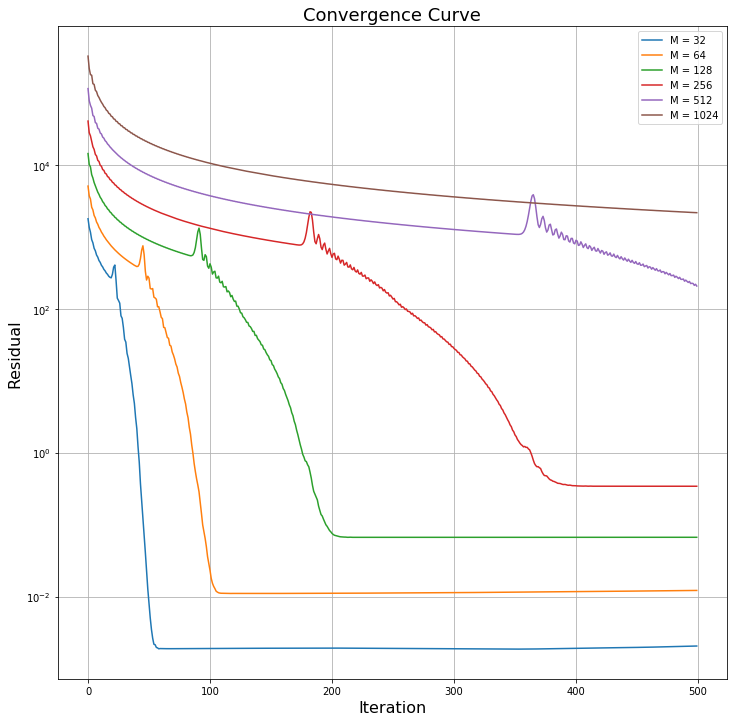

In [24]:
# Define a stopping iterations criteria.

MAXITER = 500


# Convergence investigation with M = 32.

M = 32

data32 = []

b = np.ones((M * M), dtype=np.float32)
u = np.full((M, M), 10, dtype=np.float32)

A = StencilOperatorOpenCL(M)

def cg_residual_data(xk):
    data32.append(np.linalg.norm(b - A * xk) / np.linalg.norm(b))

result, info = cg(StencilOperatorOpenCL(M), b, x0=u.flatten(), maxiter=MAXITER, callback=cg_residual_data)


# Convergence investigation with M = 64.

M = 64

data64 = []

b = np.ones((M * M), dtype=np.float32)
u = np.full((M, M), 10, dtype=np.float32)

A = StencilOperatorOpenCL(M)

def cg_residual_data(xk):
    data64.append(np.linalg.norm(b - A * xk) / np.linalg.norm(b))

result, info = cg(StencilOperatorOpenCL(M), b, x0=u.flatten(), maxiter=MAXITER, callback=cg_residual_data)


# Convergence investigation with M = 128.

M = 128

data128 = []

b = np.ones((M * M), dtype=np.float32)
u = np.full((M, M), 10, dtype=np.float32)

A = StencilOperatorOpenCL(M)

def cg_residual_data(xk):
    data128.append(np.linalg.norm(b - A * xk) / np.linalg.norm(b))

result, info = cg(StencilOperatorOpenCL(M), b, x0=u.flatten(), maxiter=MAXITER, callback=cg_residual_data)


# Convergence investigation with M = 256.

M = 256

data256 = []

b = np.ones((M * M), dtype=np.float32)
u = np.full((M, M), 10, dtype=np.float32)

A = StencilOperatorOpenCL(M)

def cg_residual_data(xk):
    data256.append(np.linalg.norm(b - A * xk) / np.linalg.norm(b))

result, info = cg(StencilOperatorOpenCL(M), b, x0=u.flatten(), maxiter=MAXITER, callback=cg_residual_data)


# Convergence investigation with M = 512.

M = 512

data512 = []

b = np.ones((M * M), dtype=np.float32)
u = np.full((M, M), 10, dtype=np.float32)

A = StencilOperatorOpenCL(M)

def cg_residual_data(xk):
    data512.append(np.linalg.norm(b - A * xk) / np.linalg.norm(b))

result, info = cg(StencilOperatorOpenCL(M), b, x0=u.flatten(), maxiter=MAXITER, callback=cg_residual_data)


# Convergence investigation with M = 1024.

M = 1024

data1024 = []

b = np.ones((M * M), dtype=np.float32)
u = np.full((M, M), 10, dtype=np.float32)

A = StencilOperatorOpenCL(M)

def cg_residual_data(xk):
    data1024.append(np.linalg.norm(b - A * xk) / np.linalg.norm(b))

result, info = cg(StencilOperatorOpenCL(M), b, x0=u.flatten(), maxiter=MAXITER, callback=cg_residual_data)


fig = plt.figure(figsize=(12.0, 12.0))

plt.semilogy(range(MAXITER), data32, label="M = 32")
plt.semilogy(range(MAXITER), data64, label="M = 64")
plt.semilogy(range(MAXITER), data128, label="M = 128")
plt.semilogy(range(MAXITER), data256, label="M = 256")
plt.semilogy(range(MAXITER), data512, label="M = 512")
plt.semilogy(range(MAXITER), data1024, label="M = 1024")

plt.xlabel("Iteration", fontsize=16)
plt.ylabel("Residual", fontsize=16)

plt.title("Convergence Curve", fontsize=18)

plt.legend()
plt.grid()
plt.show()

As can be seen in the plot above...

## Iteration Increases as M Increases Investigation

Using the data generated in the previous section an investigation was carried out to detemine the number of iterations required before the difference between successive iterations was less that a speficed tolerance.

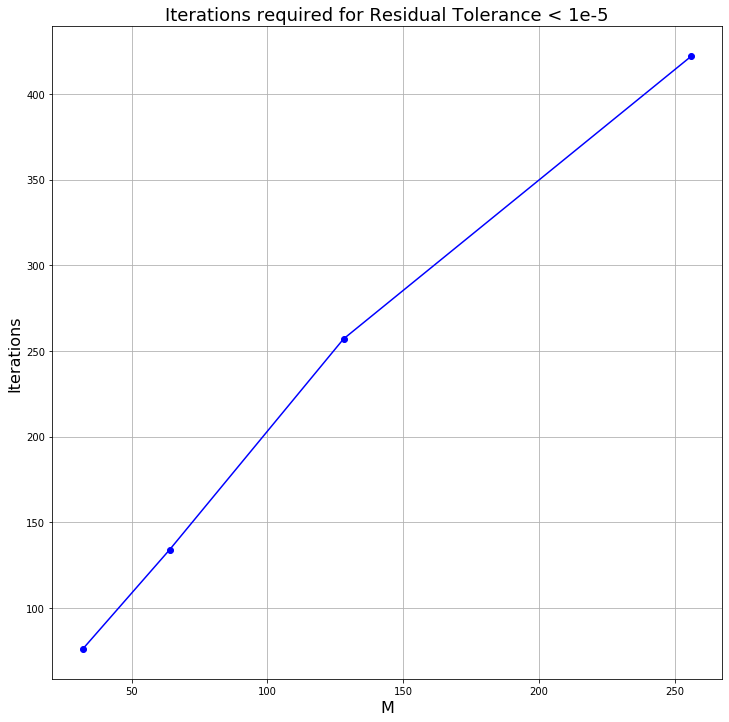

In [25]:
# Set tolerance less to than precision of float32.

TOL = 1e-5

convergence_iterations = []

# Loop over each residual data array. 

for data in [data32, data64, data128, data256]:
    for i in range (1,MAXITER):
        if abs(((data[i] - data[i - 1]) / data[i])) < TOL:
            convergence_iterations.append(i)
            break

    
fig = plt.figure(figsize=(12.0, 12.0))

plt.plot([32, 64, 128, 256], convergence_iterations, marker='o', color='b')

plt.xlabel("M", fontsize=16)
plt.ylabel("Iterations", fontsize=16)

plt.title("Iterations required for Residual Tolerance < 1e-5", fontsize=18)

plt.grid()
plt.show()

As can been seen from the plot above, the number of iterations required to achieve a residual within a specified tolerance scales linearly with M.

## Plots of the Solution u on the Unit Square

This section produces nice plots of the solution *u* on the unit square. The SciPy *cg* iterative solver is used so that a plot of the solution at each iteration is produced and plotted.

Although the grid is a 2-dimensional M x M matrix, I have elected to plot the solution in 3D for nicer/better visualisation. The Z value is the value of the solution at the point (xi, yi).

In [26]:
# Define a 3D plot function.

from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
from matplotlib.ticker import LinearLocator, FormatStrFormatter

def plot(m, n, data):
    """
    This function...
    """
    fig = plt.figure(figsize=[10, 8])
    ax = fig.gca(projection='3d')

    M = range(m)
    N = range(n)
    M, N = np.meshgrid(M, N)
    Z = data[M, N]

    surf = ax.plot_surface(M, N, Z, cmap=cm.coolwarm, linewidth=0, antialiased=False)

    ax.zaxis.set_major_locator(LinearLocator(10))
    ax.zaxis.set_major_formatter(FormatStrFormatter('%.02f'))

    fig.colorbar(surf, shrink=0.5, aspect=5)

    plt.show()

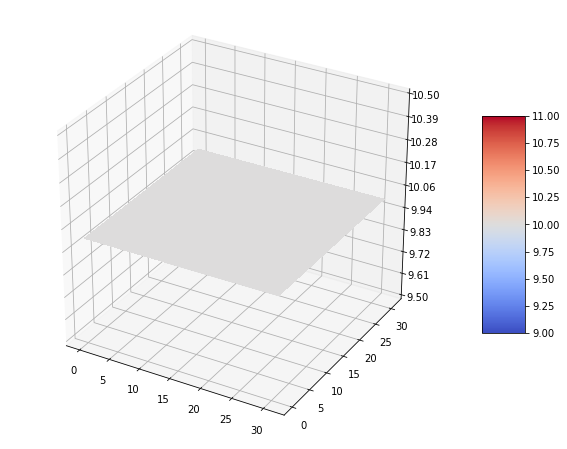

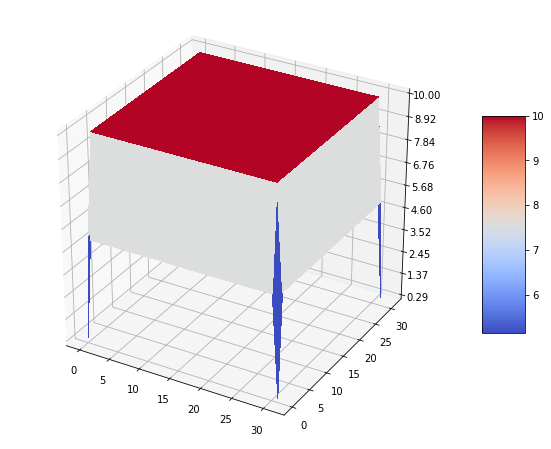

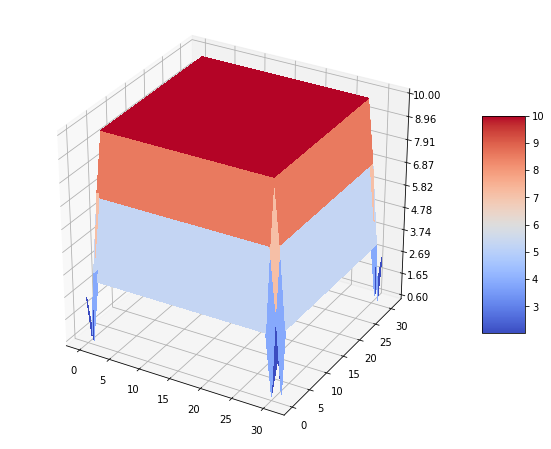

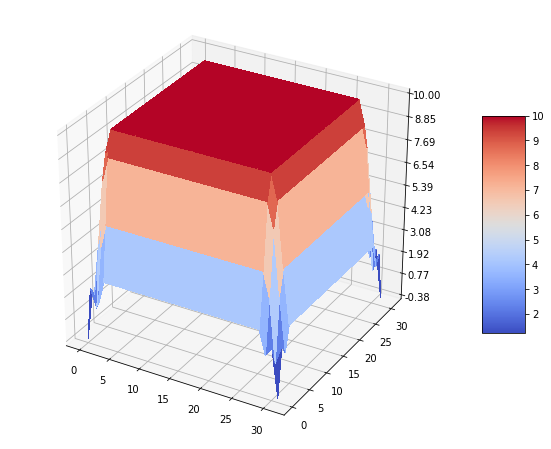

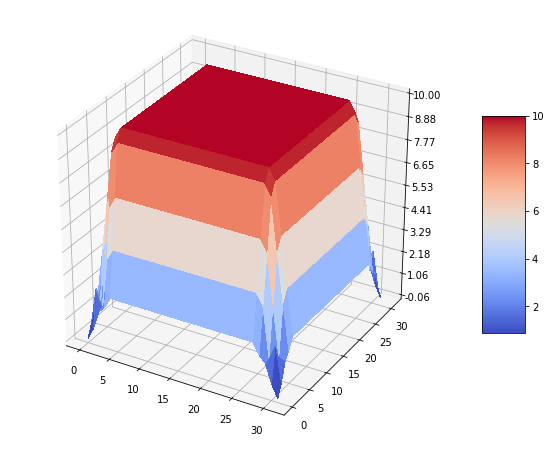

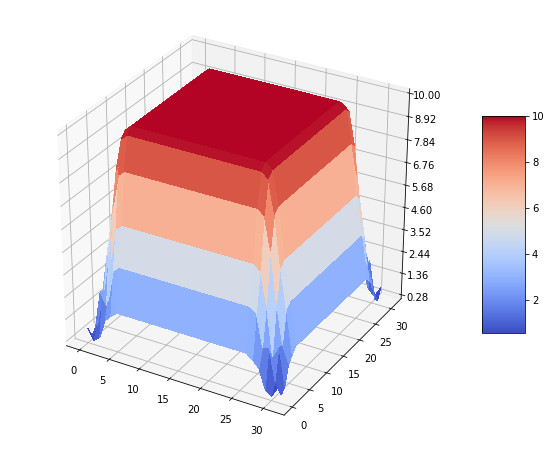

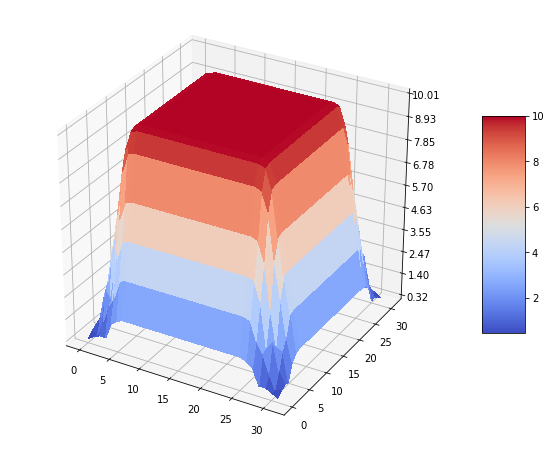

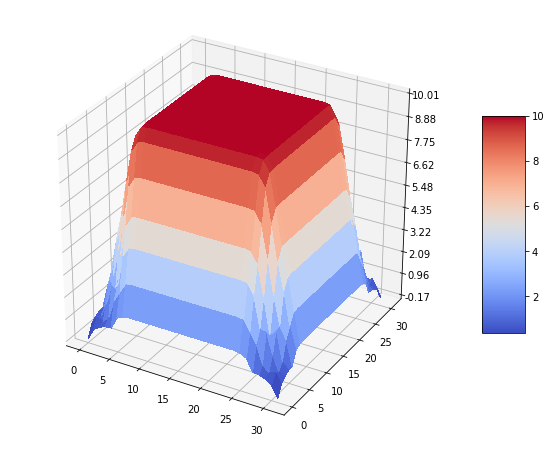

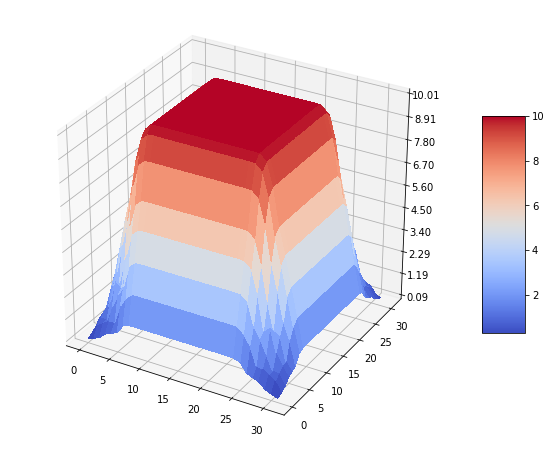

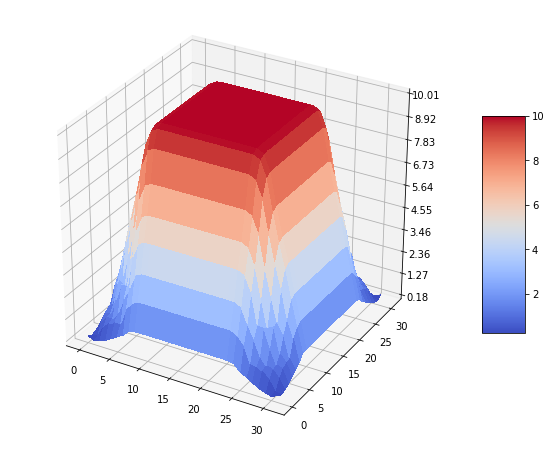

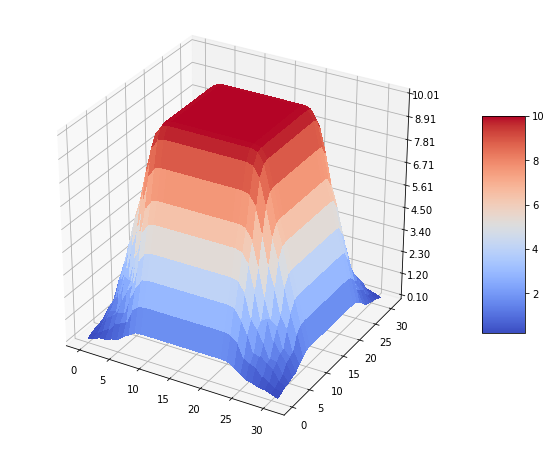

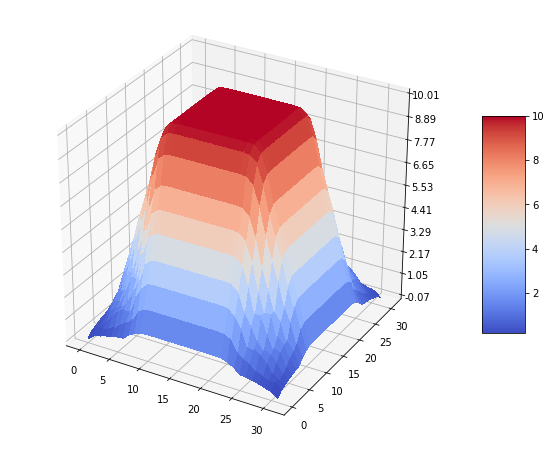

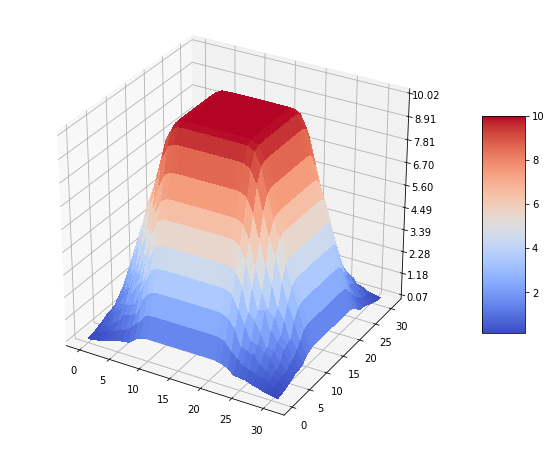

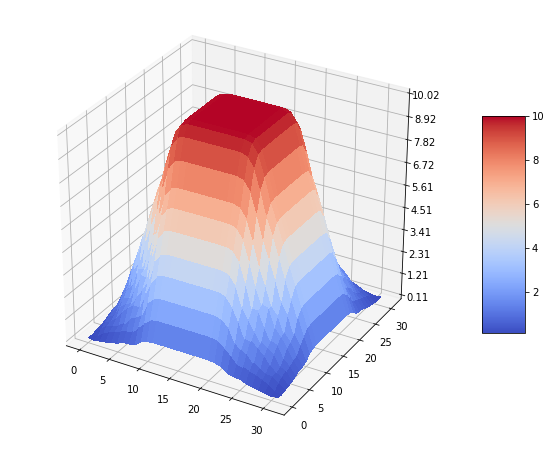

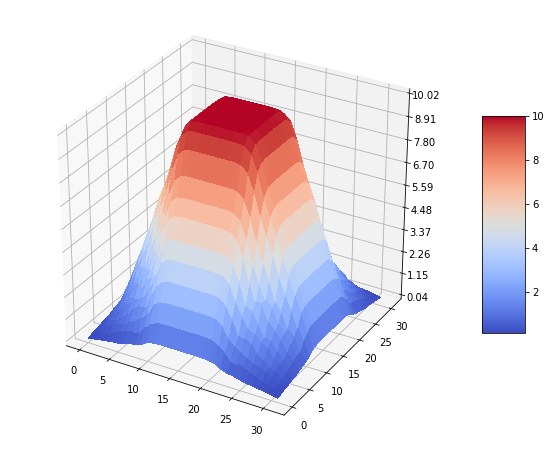

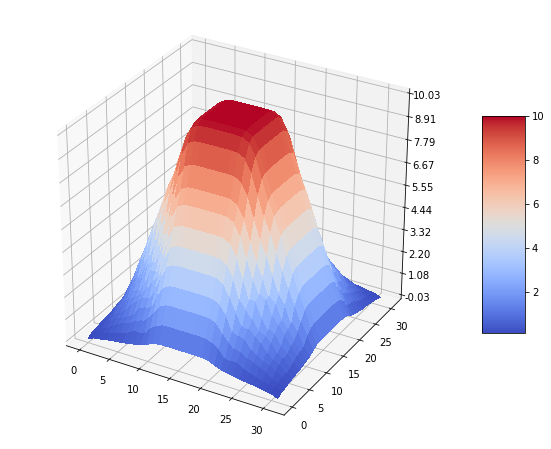

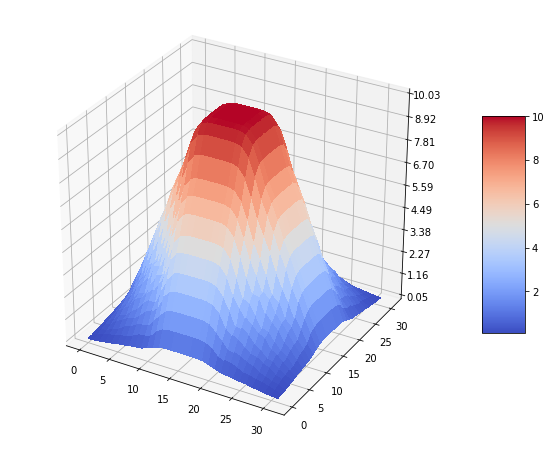

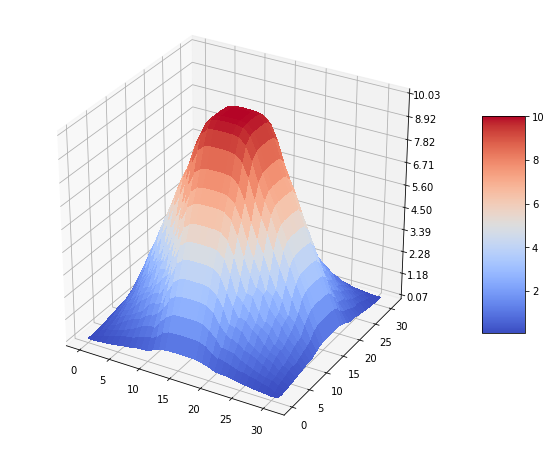

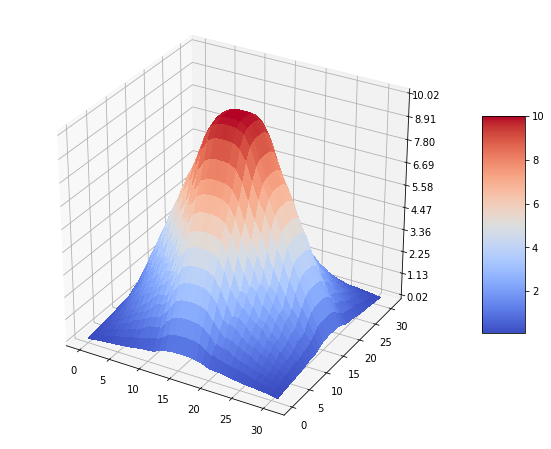

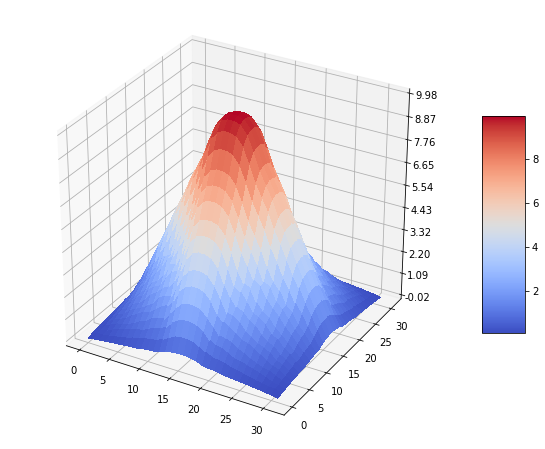

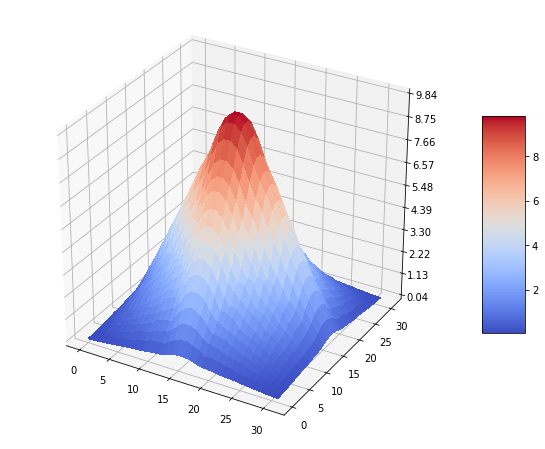

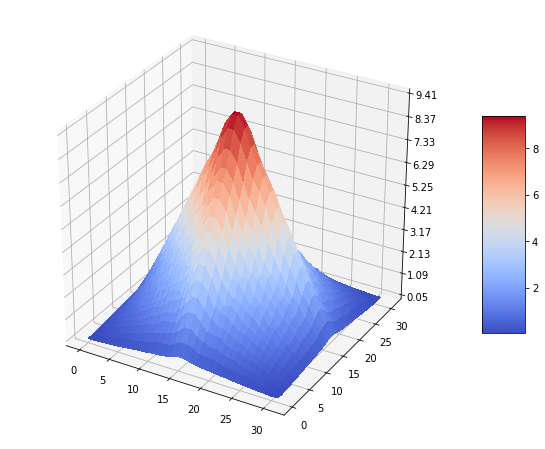

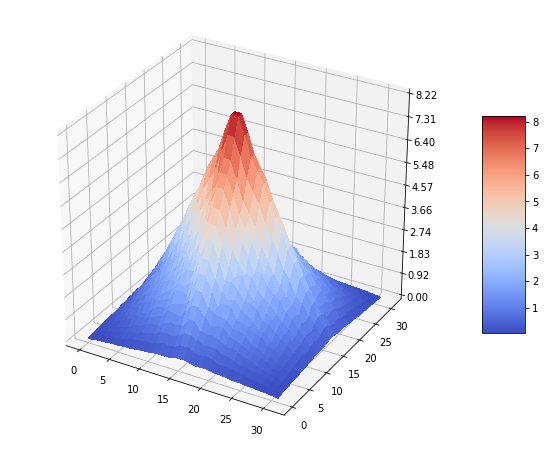

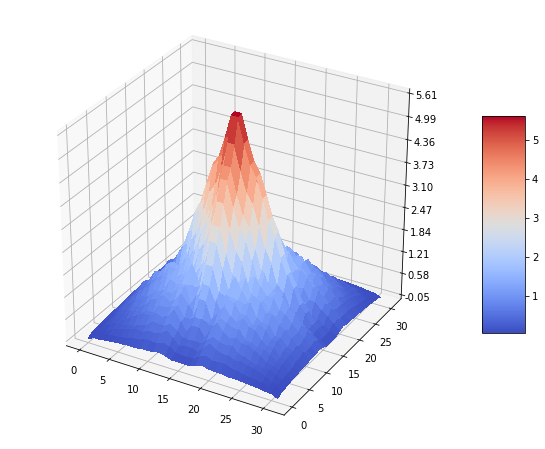

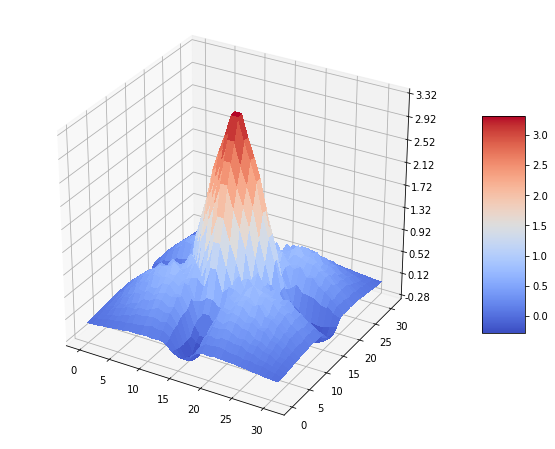

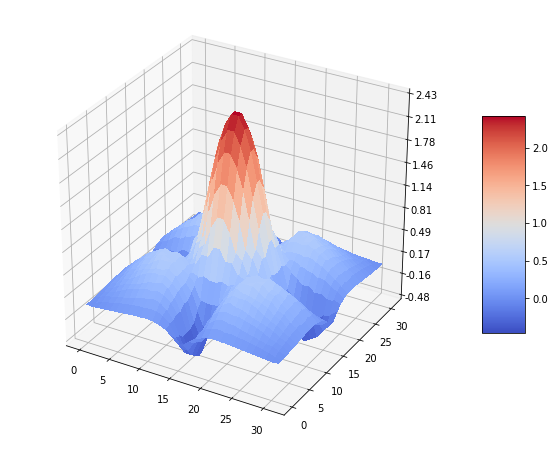

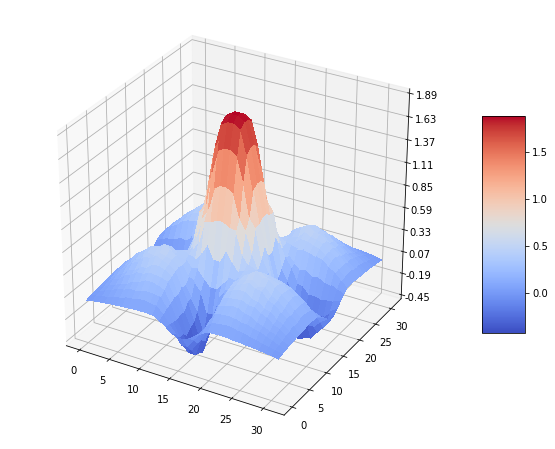

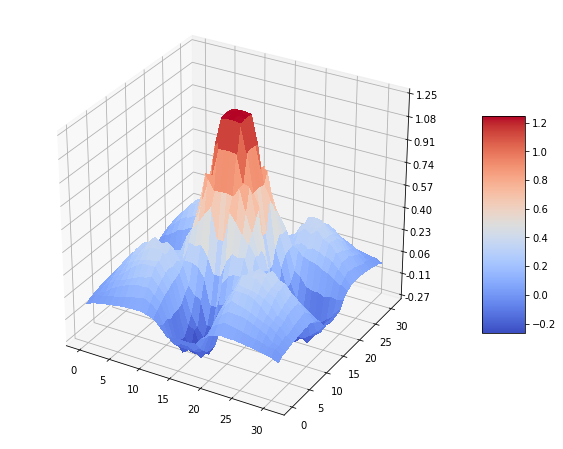

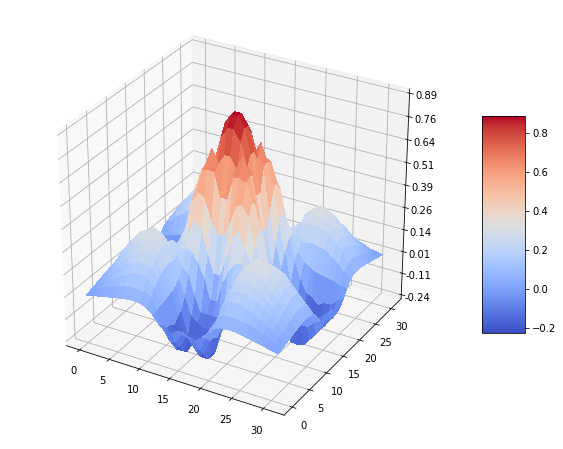

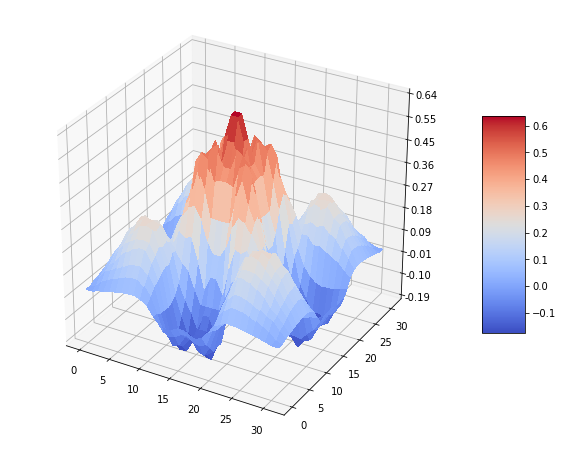

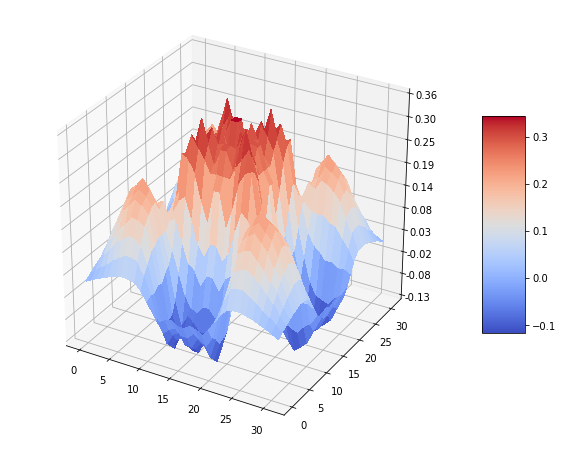

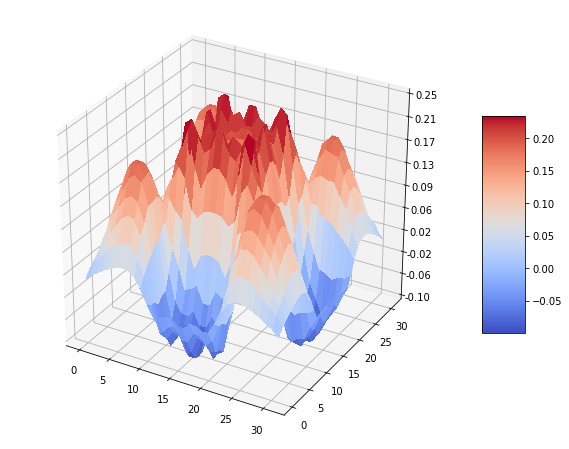

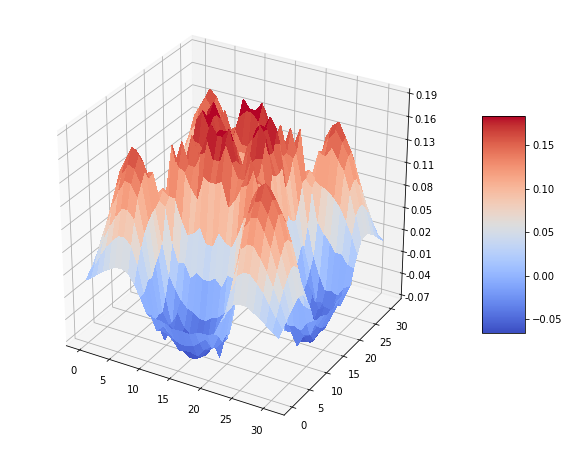

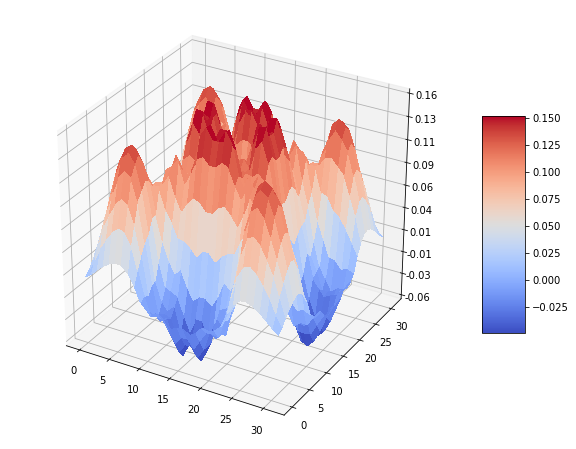

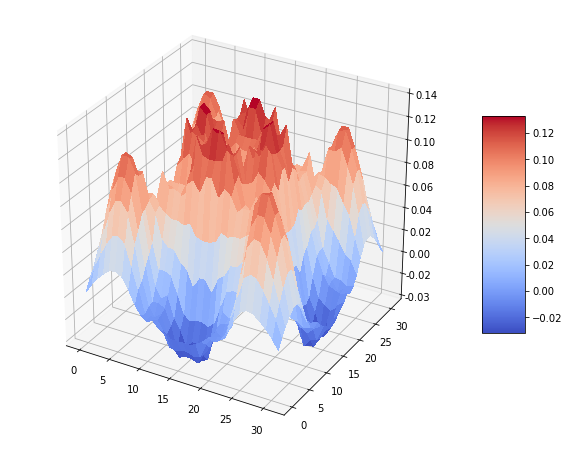

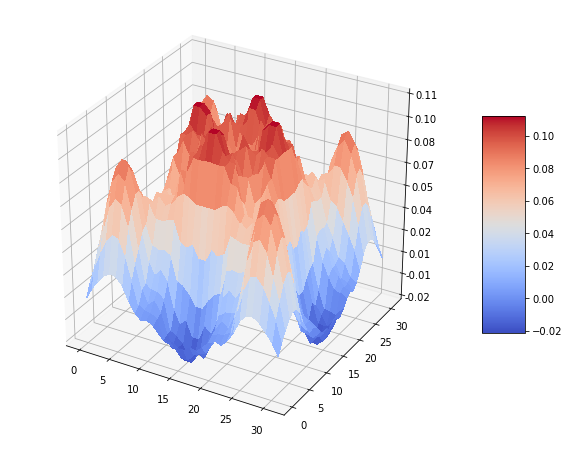

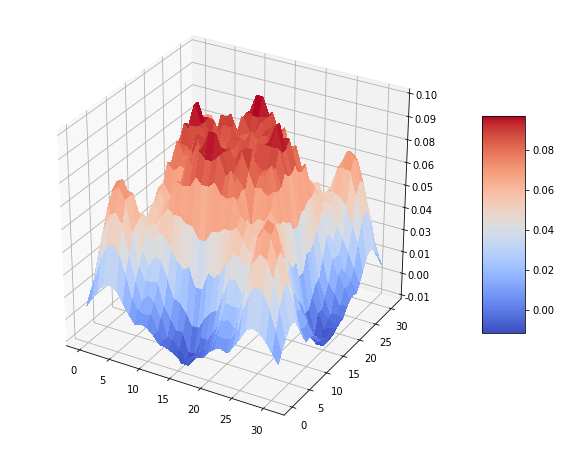

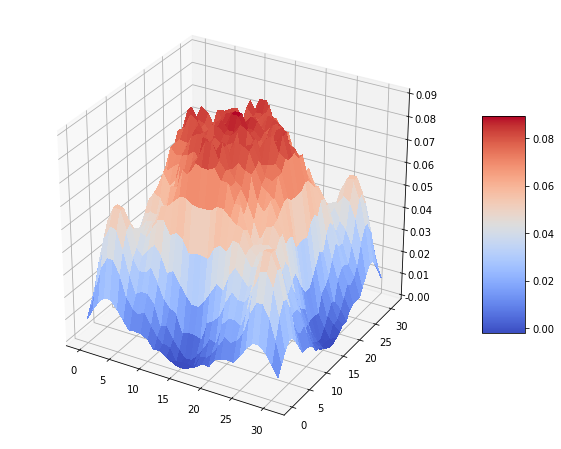

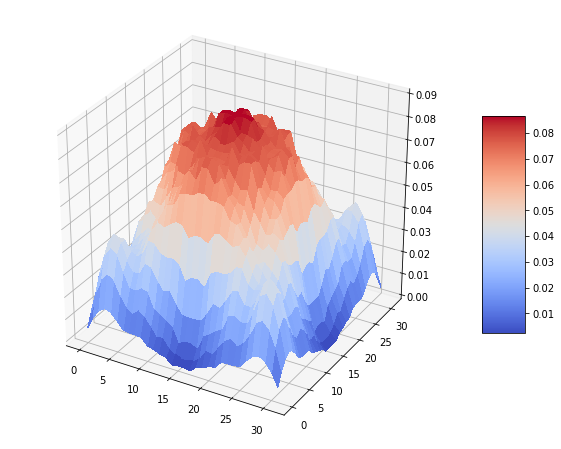

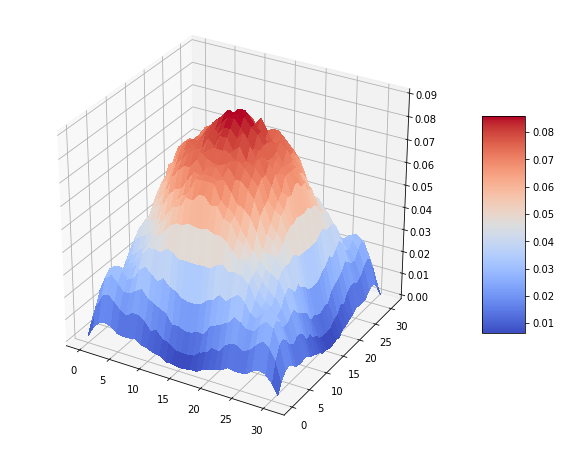

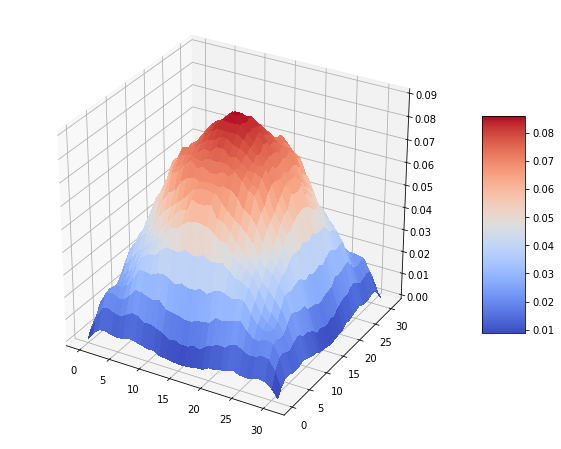

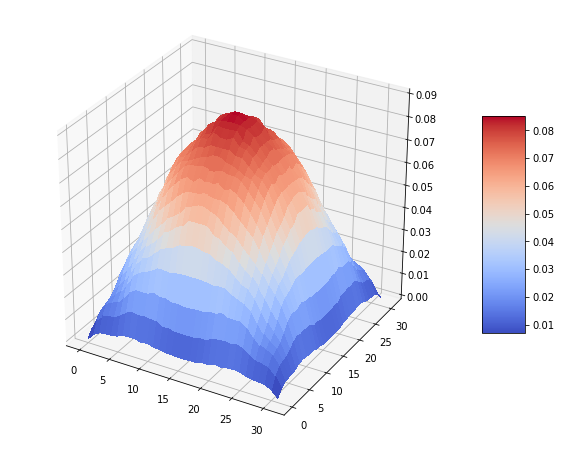

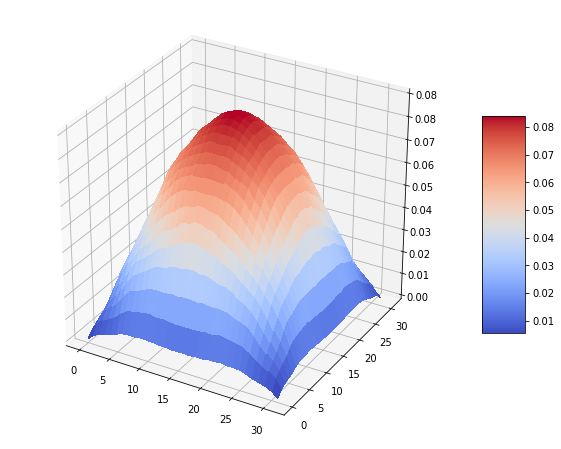

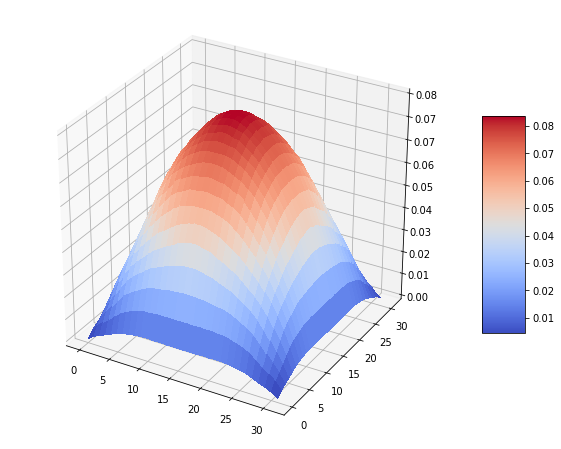

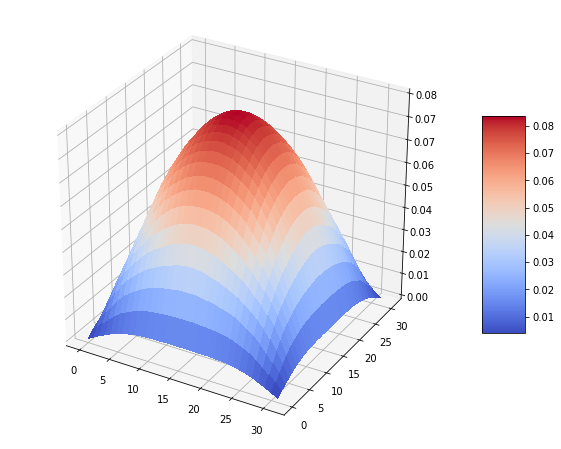

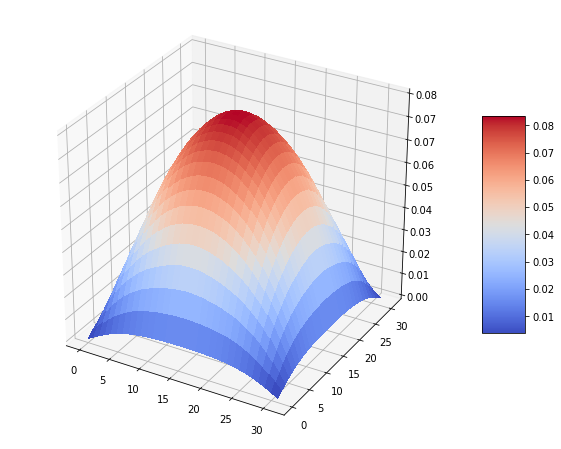

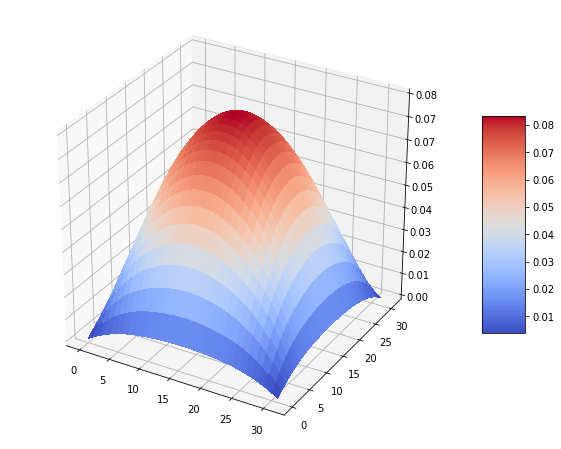

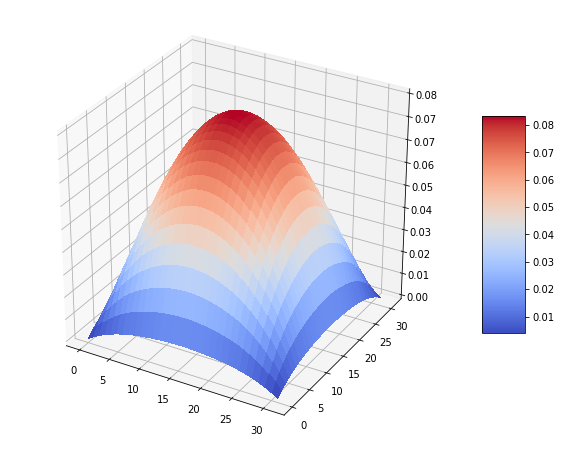

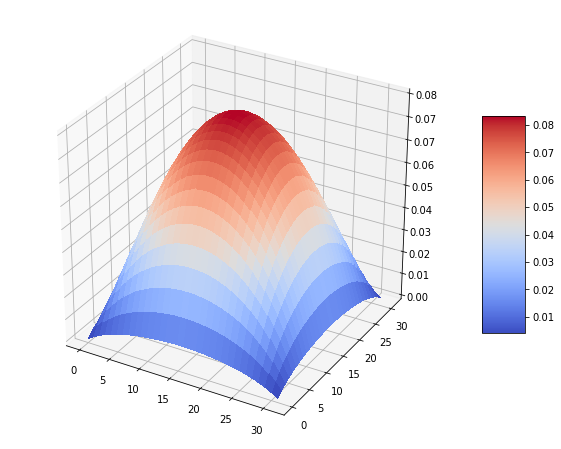

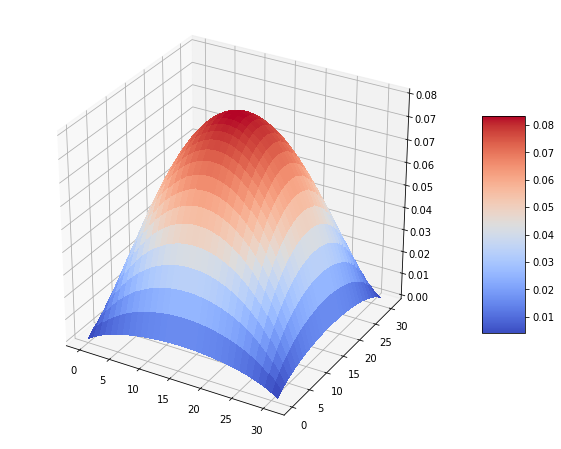

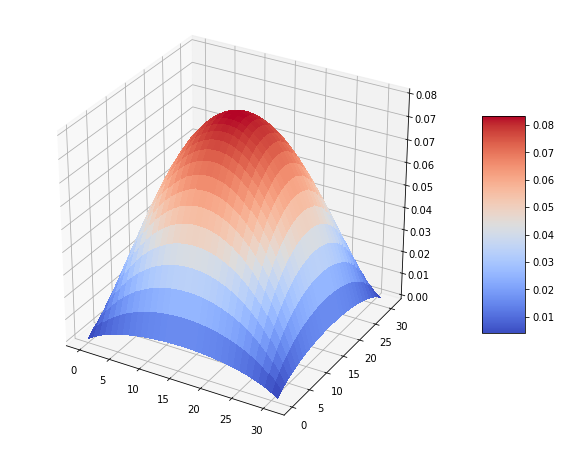

In [27]:
# Use SciPy cg to produce the data for nice plots at each iteration.

M = 32

u = np.full((M, M), 10, dtype=np.float32)
b = np.ones((M * M), dtype=np.float32)

# Plot the initial vector u.

plot(M, M, u)

# Plot each iteration of the solution.

def cg_callback(xk):
    data = xk.reshape(M, M)
    plot(M, M, data)
    
solution, info = cg(StencilOperatorOpenCL(M), b, x0 = u.flatten(), maxiter = 50, callback = cg_callback)